In [25]:
import cv2
import numpy as np
from pdf2image import convert_from_path
from src.helpers import show

In [12]:
# Load the image
pages = convert_from_path("../testdaten/001.pdf")
page = pages[0]

Height: 2338, Width: 1654, Area: 3867052


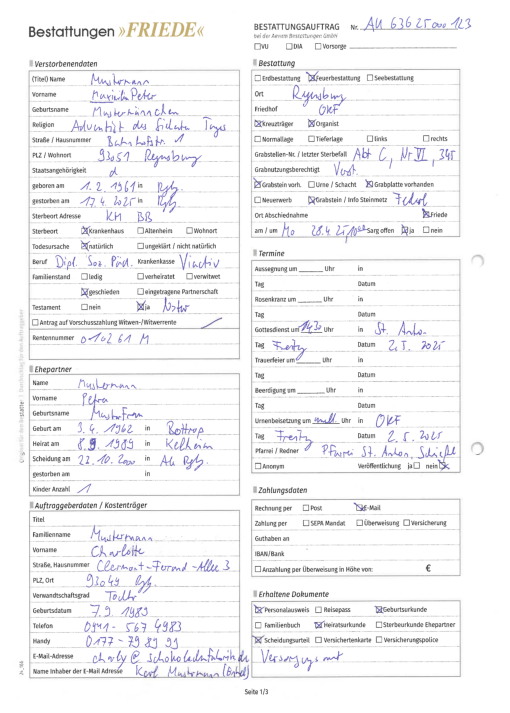

In [13]:
image = cv2.cvtColor(np.array(pages[0]), cv2.COLOR_RGB2BGR)
image = cv2.resize(image, (1654, 2338))

image_height = image.shape[0]
image_width = image.shape[1]
image_area = image_height * image_width

print(f"Height: {image_height}, Width: {image_width}, Area: {image_area}")

show(image)


# Document Scan


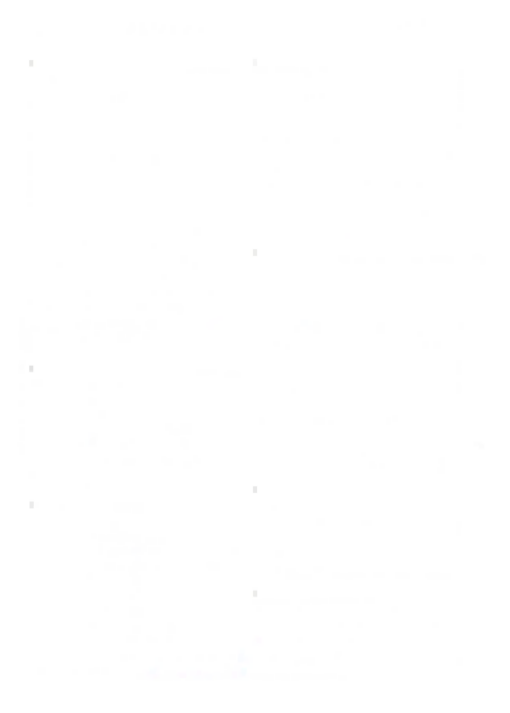

In [14]:
# Repeated Closing operation to remove text from the document.
kernel = np.ones((5, 5), np.uint8)
without_text = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=3)
resized = cv2.resize(without_text, (512, 728))

show(resized)


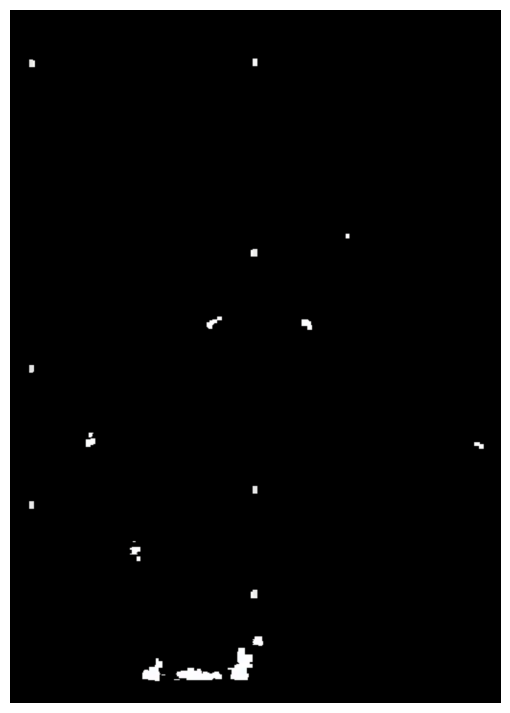

In [16]:
mask = np.zeros(resized.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

rect = (20, 20, resized.shape[1] - 20, resized.shape[0] - 20)
cv2.grabCut(resized, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
scanned = cv2.resize(resized * mask2[:, :, np.newaxis], (image_width, image_height))
show(scanned)


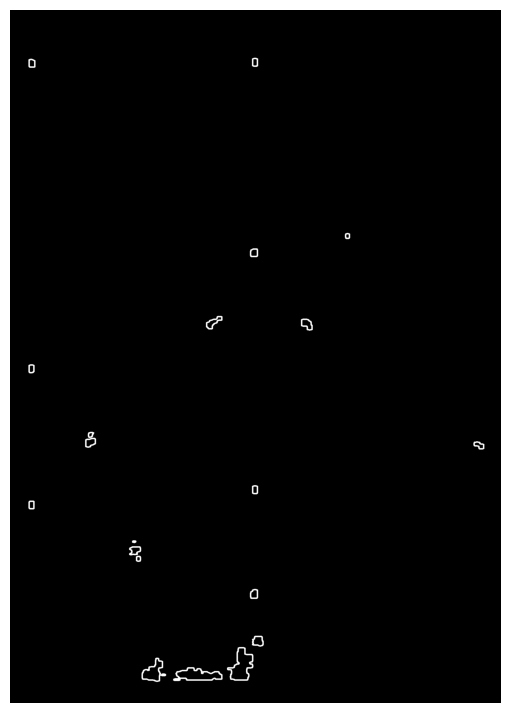

In [17]:
gray = cv2.cvtColor(scanned, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge Detection.
canny = cv2.Canny(gray, 0, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
show(canny)


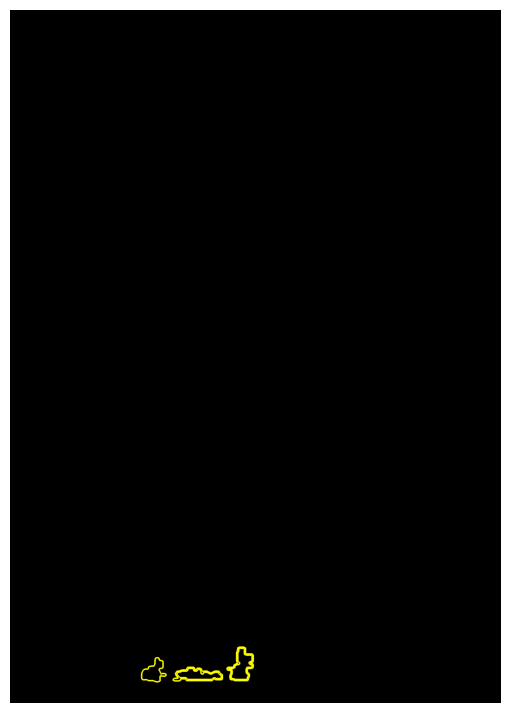

In [18]:
con = np.zeros_like(image)
# Finding contours for the detected edges.
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the largest detected contour.
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)
show(con)


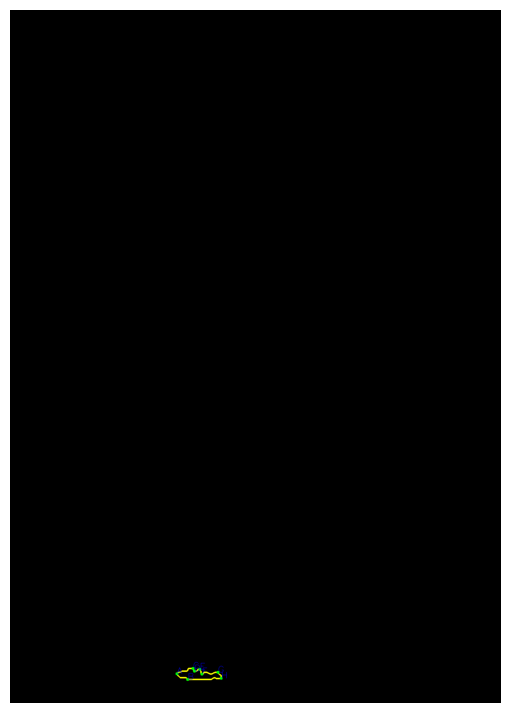

In [19]:
# Blank canvas.
con = np.zeros_like(image)
# Loop over the contours.
for c in page:
    # Approximate the contour.
    epsilon = 0.02 * cv2.arcLength(c, True)
    corners = cv2.approxPolyDP(c, epsilon, True)
    # If our approximated contour has four points
    if len(corners) == 4:
        break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# Sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())

# Displaying the corners.
for index, c in enumerate(corners):
    character = chr(65 + index)
    cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)

show(con)

In [20]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()


In [22]:
def perspective_transform(image, corners):
    if len(corners) < 4:
        print("Could not find enough corners. Returning original image.")
        return image

    (tl, tr, br, bl) = order_points(corners)
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    destination_corners_contour = np.array(destination_corners).reshape((-1, 1, 2)).astype(np.int32)
    area = cv2.contourArea(destination_corners_contour)

    if area / image_area < 0.7:
        print("Transformed image would be too small. Returning original image.")
        return image

    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32((tl, tr, br, bl)), np.float32(destination_corners))
    # Perspective transform using homography.
    return cv2.warpPerspective(image, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)


Transformed image would be too small. Returning original image.


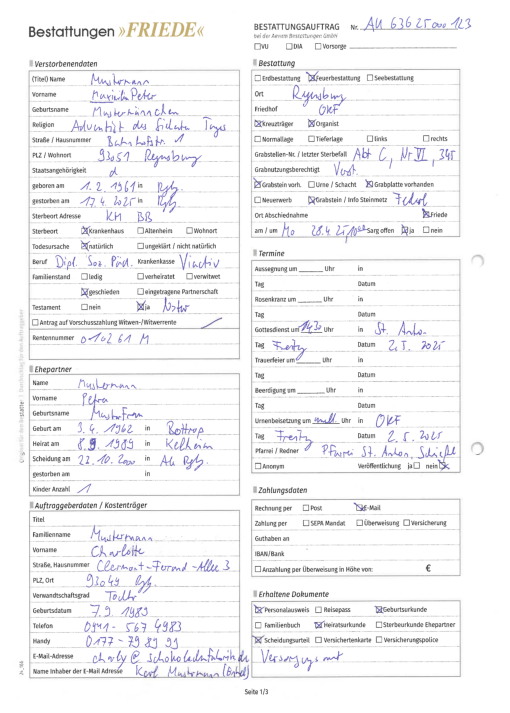

In [23]:
image = perspective_transform(image, corners)
show(image)